# NB06 — Transformer Model Training

**Goal**: Train a Transformer Encoder with **extractable attention weights** to compare global context vs. BiLSTM temporal context.

### Refinements (v2 - Normalized & Interpretable):
- **Interpretable Architecture**: Custom Transformer blocks using `nn.MultiheadAttention` to expose attention maps.
- **Normalized Training**: Matches NB05 v3/v4 with **20-epoch warmup** and **15-epoch patience**.
- **Stability Tweaks**: `nhead` reduced to **4** for the low-diversity TVSum dataset.
- **Speed Comparison**: Logs training time per epoch.
- **No Sigmoid**: raw scores used with evaluation-time clamping/hubert loss for consistency.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from pathlib import Path
import math
import json
import time
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import spearmanr

# Set seeds
torch.manual_seed(42)
np.random.seed(42)

# Environment detection
IS_KAGGLE = Path("/kaggle/input").exists()

if IS_KAGGLE:
    FEATURES_PATH = Path("/kaggle/input/tvsum-features/tvsum_features.npy")
    TARGETS_PATH = Path("/kaggle/input/tvsum-targets/tvsum_targets.parquet")
    INDEX_PATH = Path("/kaggle/input/tvsum-frame-index/tvsum_frame_index.parquet")
    TRAIN_SPLIT = Path("/kaggle/input/tvsum-train/tvsum_train.txt")
    VAL_SPLIT = Path("/kaggle/input/tvsum-val/tvsum_val.txt")
    MODEL_DIR = Path("/kaggle/working/models")
else:
    FEATURES_PATH = Path("data/processed/tvsum_features.npy")
    TARGETS_PATH = Path("data/processed/tvsum_targets.parquet")
    INDEX_PATH = Path("data/processed/tvsum_frame_index.parquet")
    TRAIN_SPLIT = Path("data/processed/splits/tvsum_train.txt")
    VAL_SPLIT = Path("data/processed/splits/tvsum_val.txt")
    MODEL_DIR = Path("models")

MODEL_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODEL_DIR / "tvsum_transformer_v2.pth"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
print(f"Model output path: {MODEL_PATH}")

Using device: cuda
Model output path: /kaggle/working/models/tvsum_transformer_v2.pth


## 1. Data Loading & Defensive Alignment

We group our individual frames back into videos. We add strictly defensive assertions to ensure the features from NB04 match the indices from NB03.

In [2]:
features = np.load(FEATURES_PATH)
targets_df = pd.read_parquet(TARGETS_PATH)
index_df = pd.read_parquet(INDEX_PATH)

def load_split_ids(path):
    with open(path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

train_ids = load_split_ids(TRAIN_SPLIT)
val_ids = load_split_ids(VAL_SPLIT)

def group_by_video(feat, idx_df, target_df):
    video_data = {}
    for vid_id in idx_df['video_id'].unique():
        rows = idx_df[idx_df['video_id'] == vid_id].index
        video_data[vid_id] = {
            'x': torch.FloatTensor(feat[rows]),
            'y': torch.FloatTensor(target_df.iloc[rows]['importance_score'].values).view(-1, 1)
        }
    return video_data

full_data = group_by_video(features, index_df, targets_df)

class SumDataset(Dataset):
    def __init__(self, data_dict, vid_ids):
        self.ids, self.data = vid_ids, data_dict
    def __len__(self): return len(self.ids)
    def __getitem__(self, idx):
        v_id = self.ids[idx]
        return self.data[v_id]['x'], self.data[v_id]['y']

train_loader = DataLoader(SumDataset(full_data, train_ids), batch_size=1, shuffle=True)
val_loader = DataLoader(SumDataset(full_data, val_ids), batch_size=1, shuffle=False)

## 2. Interpretable Transformer Architecture

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(1), :]

class InterpretableTransformerLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=512, dropout=0.3):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Self attention
        src2, attn_weights = self.self_attn(src, src, src, need_weights=True)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feed forward
        src2 = self.linear2(self.dropout(torch.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src, attn_weights

class TransformerSummarizerV2(nn.Module):
    def __init__(self, input_dim=960, d_model=256, nhead=4, num_layers=3):
        super().__init__()
        self.project = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.pos_enc = PositionalEncoding(d_model)
        
        self.layers = nn.ModuleList([
            InterpretableTransformerLayer(d_model, nhead, dropout=0.3) 
            for _ in range(num_layers)
        ])
        
        self.head = nn.Linear(d_model, 1)
        
    def forward(self, x, return_attn=False):
        # x: [Batch, SeqLen, Dim]
        x = self.project(x)
        x = self.pos_enc(x)
        
        all_attn = []
        for layer in self.layers:
            x, attn = layer(x)
            if return_attn: all_attn.append(attn)
            
        out = self.head(x)
        if return_attn:
            return out, all_attn
        return out

model = TransformerSummarizerV2().to(DEVICE)
criterion = nn.SmoothL1Loss(beta=0.1)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

print(f"Transformer ready with {sum(p.numel() for p in model.parameters()):,} parameters.")

Transformer ready with 1,828,097 parameters.


## 3. Training Loop with Time Tracking & Warm-up

In [4]:
EPOCHS = 100
history = {'train_loss': [], 'val_loss': [], 'val_spearman': []}
best_val_rho = -1.0
patience = 15
warmup_epochs = 20
counter = 0

print("Training Start...")
for epoch in range(EPOCHS):
    start_time = time.time()
    
    # --- Training ---
    model.train()
    t_losses = []
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        t_losses.append(loss.item())
    
    scheduler.step()
    
    # --- Validation ---
    model.eval()
    v_losses, rhos = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            v_losses.append(criterion(preds, y).item())
            
            p_np = torch.clamp(preds, 0, 1).cpu().squeeze().numpy()
            y_np = y.cpu().squeeze().numpy()
            rho, _ = spearmanr(p_np, y_np)
            if not np.isnan(rho): rhos.append(rho)
            
    end_time = time.time()
    epoch_time = end_time - start_time
    
    avg_t, avg_v, avg_r = np.mean(t_losses), np.mean(v_losses), np.mean(rhos)
    history['train_loss'].append(avg_t)
    history['val_loss'].append(avg_v)
    history['val_spearman'].append(avg_r)
    
    # Improvement Tracking
    if avg_r > best_val_rho:
        best_val_rho = avg_r
        torch.save(model.state_dict(), MODEL_PATH)
        counter = 0
        print(f"-> Epoch [{epoch+1}] Improved Spearman: {avg_r:.4f}. Model saved.")
    else:
        if epoch + 1 > warmup_epochs:
            counter += 1
    
    if counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}. Best Rho: {best_val_rho:.4f}")
        break
        
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}] Loss: {avg_t:.4f} | Spearman: {avg_r:.4f} | Time: {epoch_time:.2f}s")

print(f"Success! Best Spearman: {best_val_rho:.4f}")

Training Start...
-> Epoch [1] Improved Spearman: 0.0267. Model saved.
-> Epoch [2] Improved Spearman: 0.1242. Model saved.
-> Epoch [3] Improved Spearman: 0.2619. Model saved.
-> Epoch [4] Improved Spearman: 0.2924. Model saved.
-> Epoch [5] Improved Spearman: 0.3398. Model saved.
Epoch [5] Loss: 0.1050 | Spearman: 0.3398 | Time: 0.37s
-> Epoch [6] Improved Spearman: 0.3727. Model saved.
-> Epoch [7] Improved Spearman: 0.3839. Model saved.
-> Epoch [8] Improved Spearman: 0.3908. Model saved.
-> Epoch [9] Improved Spearman: 0.4011. Model saved.
-> Epoch [10] Improved Spearman: 0.4047. Model saved.
Epoch [10] Loss: 0.0758 | Spearman: 0.4047 | Time: 0.42s
-> Epoch [11] Improved Spearman: 0.4072. Model saved.
-> Epoch [12] Improved Spearman: 0.4170. Model saved.
-> Epoch [13] Improved Spearman: 0.4229. Model saved.
-> Epoch [14] Improved Spearman: 0.4268. Model saved.
-> Epoch [15] Improved Spearman: 0.4283. Model saved.
Epoch [15] Loss: 0.0650 | Spearman: 0.4283 | Time: 0.41s
-> Epoch [1

## 4. Interpretability Visualization (Attention Map)

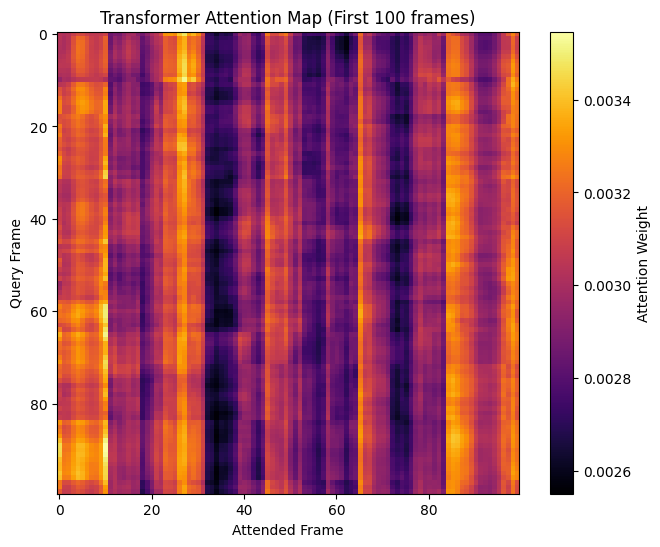

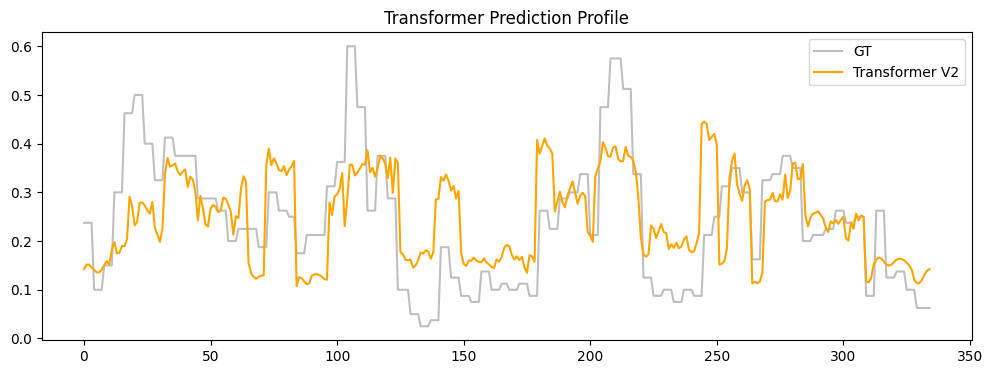

In [5]:
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

with torch.no_grad():
    x, y = next(iter(val_loader))
    preds, attn_maps = model(x.to(DEVICE), return_attn=True)
    
    # Get attention from the last layer [Batch, Head, Seq, Seq] -> actually MHA returns [Batch, Seq, Seq] averaged over heads
    # attn_maps[-1] is [1, Seq, Seq]
    last_attn = attn_maps[-1].cpu().squeeze().numpy()
    
    plt.figure(figsize=(8, 6))
    # Show a zoomed-in 100x100 segment of the attention matrix for clarity
    plt.imshow(last_attn[:100, :100], cmap='inferno')
    plt.title("Transformer Attention Map (First 100 frames)")
    plt.xlabel("Attended Frame")
    plt.ylabel("Query Frame")
    plt.colorbar(label="Attention Weight")
    plt.show()
    
    # Plot prediction vs GT
    p_np = torch.clamp(preds, 0, 1).cpu().squeeze().numpy()
    y_np = y.squeeze().numpy()
    
    plt.figure(figsize=(12, 4))
    plt.plot(y_np, color='gray', alpha=0.5, label='GT')
    plt.plot(p_np, color='orange', label='Transformer V2')
    plt.title("Transformer Prediction Profile")
    plt.legend()
    plt.show()